# Features from installments_payments dataset

This notebook creates features from the installments_payments dataset and displays the distribution of both categorical and numerical features. The installments_payments dataset contains the repayment history for the previously disbursed credits with Home Credit.

In [1]:
# Importing main modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
%matplotlib inline
pd.set_option('display.max_columns', 2000)

# Defining standard plot options
sns.set(font_scale=1.4)
sns.set_style("white")

# Reverting to old color palette
pal = sns.color_palette("deep")
pal = pal.as_hex()
pal[1], pal[2], pal[3] = pal[2], pal[3], pal[1]
sns.set_palette(pal)

In [2]:
# Loading application dataframe from csv file 
application = pd.read_csv("./data/application.csv")

In [3]:
# Reading data files into csv format
installments_payments = pd.read_csv("./data/installments_payments.csv")
homecredit_columns_description = pd.read_csv("./data/homecredit_columns_description.csv", encoding="ISO-8859-1")

In [4]:
# Description of columns in previous_application dataset
description_application = homecredit_columns_description[homecredit_columns_description["Table"] == "installments_payments.csv"]
for index, row in description_application.iterrows():
    print(row["Row"], row["Description"])

installments_payments.head(20)

SK_ID_PREV  ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
SK_ID_CURR ID of loan in our sample
NUM_INSTALMENT_VERSION Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
NUM_INSTALMENT_NUMBER On which installment we observe payment
DAYS_INSTALMENT When the installment of previous credit was supposed to be paid (relative to application date of current loan)
DAYS_ENTRY_PAYMENT When was the installments of previous credit paid actually (relative to application date of current loan)
AMT_INSTALMENT What was the prescribed installment amount of previous credit on this installment
AMT_PAYMENT What the client actually paid on previous credit on this installment


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
5,1137312,164489,1.0,12,-1384.0,-1417.0,5970.375,5970.375
6,2234264,184693,4.0,11,-349.0,-352.0,29432.295,29432.295
7,1818599,111420,2.0,4,-968.0,-994.0,17862.165,17862.165
8,2723183,112102,0.0,14,-197.0,-197.0,70.740,70.740
9,1413990,109741,1.0,4,-570.0,-609.0,14308.470,14308.470


In [5]:
# Extraction of features from installments_payments dataset

# Creating empty lists for each new feature
nb_inst_pay_credits_list = []
nb_inst_payments_list = []
days_last_req_inst_list = []
days_last_inst_pay_list = []
avg_delay_inst_pay_list = []
max_delay_inst_pay_list = []
avg_inst_req_list = []
avg_inst_pay_list = []
fr_inst_pay_req_list = []
nb_late_inst_pay_list = []
fr_late_inst_pay_list = []
nb_incomplete_inst_pay_list = []
fr_incomplete_inst_pay_list = []
max_reworked_inst_list = []

counter = 0
lenght = len(application)
for index, row in application.iterrows():
    counter += 1
    sys.stdout.write('\r'+"Progress:"+str(round(counter/lenght*100,1))+"%")
 
    nb_inst_pay_credits = 0
    nb_inst_payments = 0
    days_last_req_inst = np.NaN
    days_last_inst_pay = np.NaN
    avg_delay_inst_pay = np.NaN
    max_delay_inst_pay = np.NaN
    avg_inst_req = np.NaN
    avg_inst_pay = np.NaN
    fr_inst_pay_req = np.NaN
    nb_late_inst_pay = 0
    fr_late_inst_pay = np.NaN
    nb_incomplete_inst_pay = 0
    fr_incomplete_inst_pay = np.NaN
    max_reworked_inst = np.NaN

    df = installments_payments[installments_payments["SK_ID_CURR"] == row["SK_ID_CURR"]].sort_values(by="NUM_INSTALMENT_NUMBER", ascending = False)
    if len(df) > 0:
        unique_credit = df["SK_ID_PREV"].unique()
        # Number of past installment payments credits
        nb_inst_pay_credits = len(unique_credit)
        # Number of past installment payments
        nb_inst_payments = len(df)
        # Days since last required installment
        days_last_req_inst = df["DAYS_INSTALMENT"].min()
        # Days since last installment payment
        days_last_inst_pay = df["DAYS_ENTRY_PAYMENT"].min()
        # Average delay in installment payments
        avg_delay_inst_pay = (df["DAYS_INSTALMENT"] - df["DAYS_ENTRY_PAYMENT"]).mean()
        # Maximum delay in installment payments
        max_delay_inst_pay = (df["DAYS_INSTALMENT"] - df["DAYS_ENTRY_PAYMENT"]).max()
        # Average installment required
        avg_inst_req = df["AMT_INSTALMENT"].mean()
        # Average installment payments
        avg_inst_pay= df["AMT_PAYMENT"].mean()
        # Fraction installment payments over required
        if avg_inst_req > 0:
            fr_inst_pay_req = avg_inst_pay/avg_inst_req
        # Number of late installment payments
        nb_late_inst_pay = len(df[df["DAYS_INSTALMENT"] < df["DAYS_ENTRY_PAYMENT"]])
        # Fraction of late installment payments
        if nb_inst_payments > 0:
            fr_late_inst_pay = nb_late_inst_pay/nb_inst_payments
        # Number of incomplete installment payments
        nb_incomplete_inst_pay = len(df[df["AMT_PAYMENT"] < df["AMT_INSTALMENT"]])
        # Fraction of late installment payments
        if nb_inst_payments > 0:
            fr_incomplete_inst_pay = nb_incomplete_inst_pay/nb_inst_payments
        # Maximum number of reworked installments
        max_reworked_inst = df["NUM_INSTALMENT_VERSION"].max()
        
        
    nb_inst_pay_credits_list.append(nb_inst_pay_credits)
    nb_inst_payments_list.append(nb_inst_payments)
    days_last_req_inst_list.append(days_last_req_inst)
    days_last_inst_pay_list.append(days_last_inst_pay)
    avg_delay_inst_pay_list.append(avg_delay_inst_pay)
    max_delay_inst_pay_list.append(max_delay_inst_pay)
    avg_inst_req_list.append(avg_inst_req)
    avg_inst_pay_list.append(avg_inst_pay)
    fr_inst_pay_req_list.append(fr_inst_pay_req)
    nb_late_inst_pay_list.append(nb_late_inst_pay)
    fr_late_inst_pay_list.append(fr_late_inst_pay)
    nb_incomplete_inst_pay_list.append(nb_incomplete_inst_pay)
    fr_incomplete_inst_pay_list.append(fr_incomplete_inst_pay)
    max_reworked_inst_list.append(max_reworked_inst)

Progress:100.0%

In [6]:
# Function to display description of selected feature
def add_description(table, row, description):
    list_description = [np.NaN, table, row, description, np.NaN]
    homecredit_columns_description.loc[len(homecredit_columns_description)] = list_description
    return homecredit_columns_description

In [7]:
# Creation of new features from installment_payments dataset
application["nb_inst_pay_credits_list"] = nb_inst_pay_credits_list
add_description("installment_payments.csv", "nb_inst_pay_credits_list", "Number of past installment payments credits")

application["nb_inst_payments_list"] = nb_inst_payments_list
add_description("installment_payments.csv", "nb_inst_payments_list", "Number of past installment payments")

application["days_last_req_inst_list"] = days_last_req_inst_list
add_description("installment_payments.csv", "days_last_req_inst_list", "Days since last required installment")

application["days_last_inst_pay_list"] = days_last_inst_pay_list
add_description("installment_payments.csv", "days_last_inst_pay_list", "Days since last installment payment")

application["avg_delay_inst_pay_list"] = avg_delay_inst_pay_list
add_description("installment_payments.csv", "avg_delay_inst_pay_list", "Average delay in installment payments")

application["max_delay_inst_pay_list"] = max_delay_inst_pay_list
add_description("installment_payments.csv", "max_delay_inst_pay_list", "Maximum delay in installment payments")

application["avg_inst_req_list"] = avg_inst_req_list
add_description("installment_payments.csv", "avg_inst_req_list", "Average installment required")

application["avg_inst_pay_list"] = avg_inst_pay_list
add_description("installment_payments.csv", "avg_inst_pay_list", "Average installment payments")

application["fr_inst_pay_req_list"] = fr_inst_pay_req_list
add_description("installment_payments.csv", "fr_inst_pay_req_list", "Fraction installment payments over required")

application["nb_late_inst_pay_list"] = nb_late_inst_pay_list
add_description("installment_payments.csv", "nb_late_inst_pay_list", "Number of late installment payments")

application["fr_late_inst_pay_list"] = fr_late_inst_pay_list
add_description("installment_payments.csv", "fr_late_inst_pay_list", "Fraction of late installment payments")

application["nb_incomplete_inst_pay_list"] = nb_incomplete_inst_pay_list
add_description("installment_payments.csv", "nb_incomplete_inst_pay_list", "Number of incomplete installment payments")

application["fr_incomplete_inst_pay_list"] = fr_incomplete_inst_pay_list
add_description("installment_payments.csv", "fr_incomplete_inst_pay_list", "Fraction of late installment payments")

application["max_reworked_inst_list"] = max_reworked_inst_list
add_description("installment_payments.csv", "max_reworked_inst_list", "Maximum number of reworked installments");


In [8]:
# Saving application dataframe into csv file
application.to_csv("./data/application.csv",index=False)

In [9]:
# Saving homecredit_columns_description dataframe into csv file
homecredit_columns_description.to_csv("./data/homecredit_columns_description.csv",index=False)

In [10]:
discrete_features = ["nb_inst_pay_credits_list"]

continuous_features = ["nb_inst_payments_list", "days_last_req_inst_list", "days_last_inst_pay_list", \
                       "avg_delay_inst_pay_list", "max_delay_inst_pay_list", "avg_inst_req_list", \
                       "avg_inst_pay_list", "fr_inst_pay_req_list", "nb_late_inst_pay_list", \
                       "fr_late_inst_pay_list", "nb_incomplete_inst_pay_list", \
                       "fr_incomplete_inst_pay_list", "max_reworked_inst_list"]

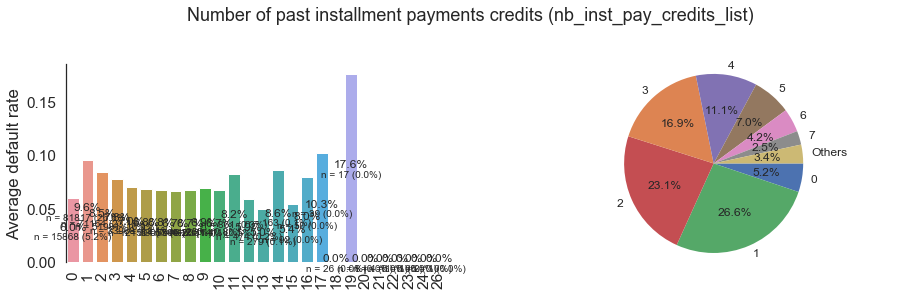

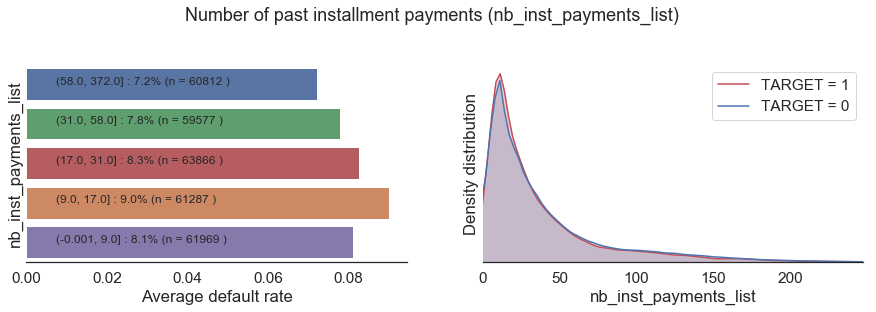

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


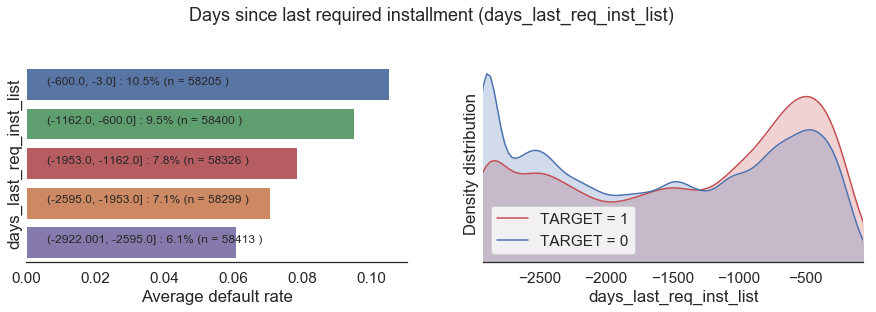

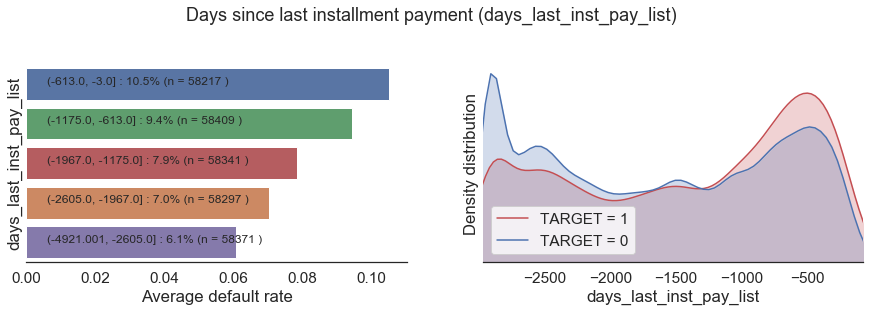

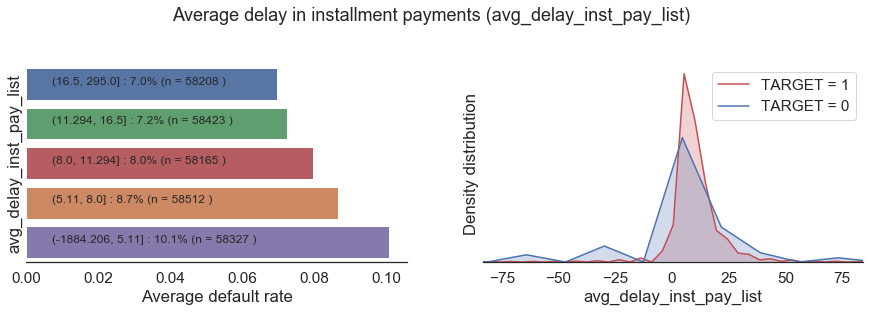

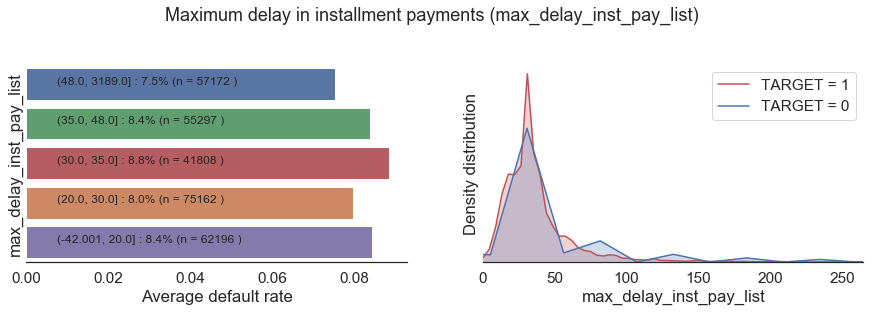

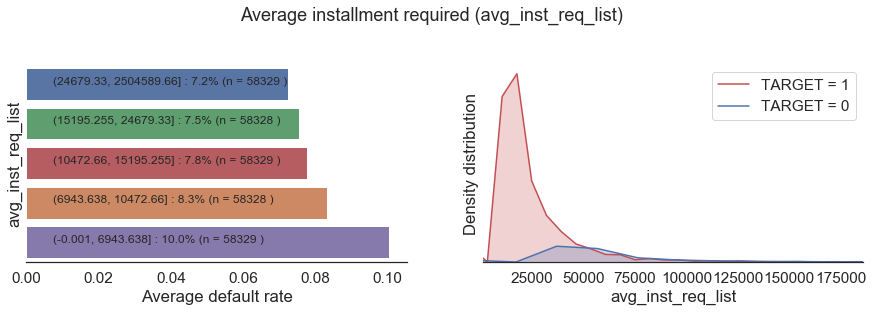

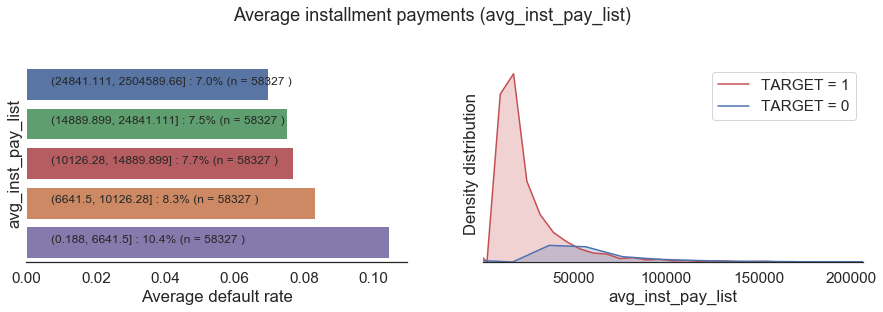

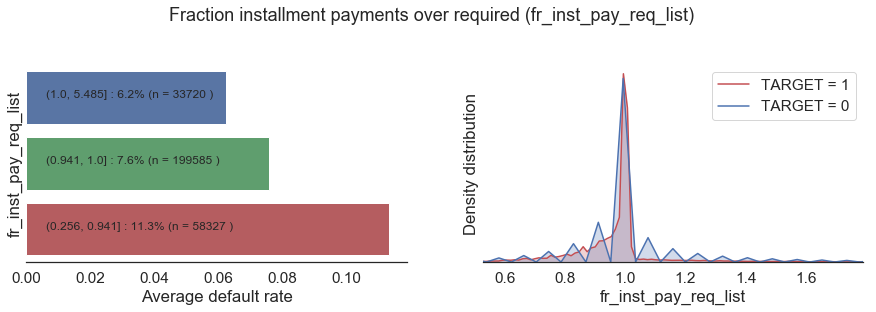

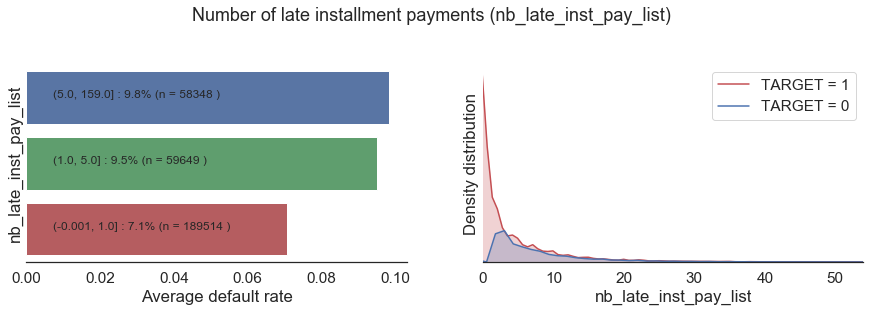

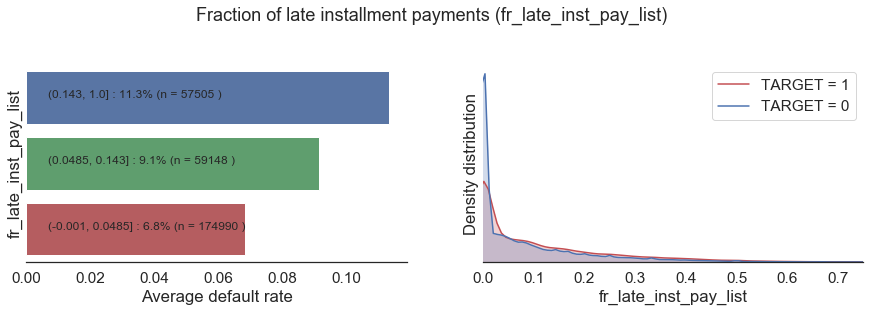

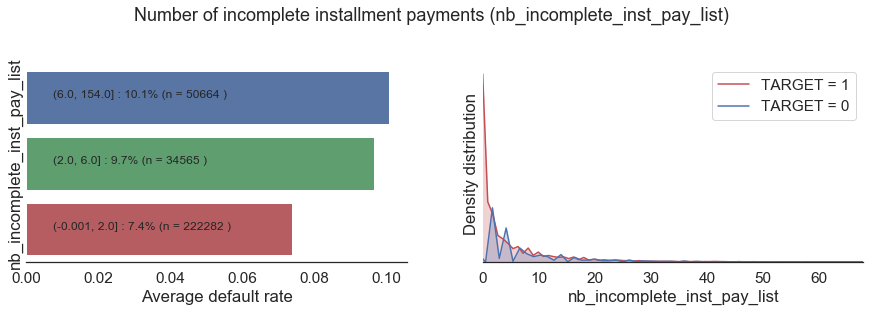

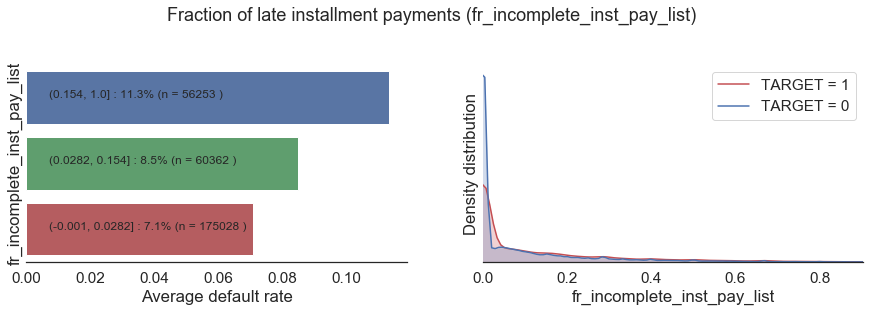

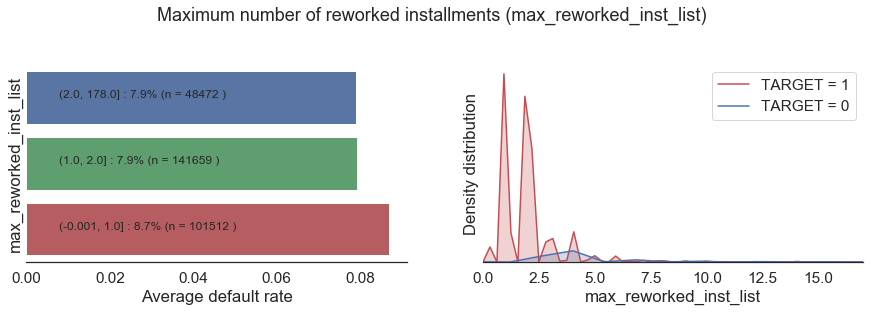

In [11]:
def display_discrete_feature(df, feature, target):
    # Creating figure and axes
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    
    # Print title
    title = homecredit_columns_description[homecredit_columns_description["Row"] == feature]["Description"].tolist()[0] + " (" + feature + ")"
    # If title is too long, reduce font size
    if len(title) <= 100:
        plt.suptitle(title, size = 18)
    else:
        plt.suptitle(title, size = 18*100/len(title))
    
    # Bar plot of mean target as a function of feature value
    df_grouped = df[[feature, target]].groupby([feature]).agg(["mean", "count"])
    # In case of non numerical categorial data, sort by value count
    if type(df_grouped.index[0]) == str:
        df_grouped = df_grouped.sort_values(by = [("TARGET", "count")], ascending = False)
    index = df_grouped.index
    height = df_grouped[("TARGET", "mean")].tolist()
    count = df_grouped[("TARGET", "count")].tolist()
    sns.barplot(index, height, ax = ax1)
    if len(count) >= 5:
        ax1.tick_params(axis='x', rotation=90, labelleft = True)
    ax1.set_xlabel("")
    ax1.set_ylabel('Average default rate')

    sns.despine(bottom=True, ax = ax1)
    # Writing target average and count for each bar plot
    for i, item in enumerate(count):
        ax1.text(x = i , y = height[i]/2, s = str(round(height[i]*100,1))+"%", size = 12, horizontalalignment='center')
        ax1.text(x = i , y = height[i]/2-np.max(height)/20, s = "n = "+str(item)+" ("+str(round(item/len(df)*100, 1))+"%)", size = 10, horizontalalignment='center')

    # Pie chart for the selected feature
    df_value_count = df[feature].value_counts()/len(df[feature].dropna())
    # In case of numerical categorial data, sort by index
    if type(df_value_count.index[0]) != str:
        df_value_count = df_value_count.sort_index()
    # If there are more than 2 categories with low count, then group in Others category
    if len(df_value_count[df_value_count < 2/100]) >= 2:
        df_value_count = df_value_count[df_value_count > 2/100]
        df_value_count["Others"] = 1 - df_value_count.sum()
    df_value_count.plot(kind="pie", autopct="%1.1f%%", ax = ax2, startangle = 0
                        , counterclock = False, textprops=dict(fontsize=12), 
                       wedgeprops = {'linewidth': 0} )
    ax2.set_ylabel("")
    ax2.axis('equal')

    plt.show()
    
    
def display_continuous_feature(df, feature, target, bins):
    # Creating figure and axes
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
   
    # Print title
    title = homecredit_columns_description[homecredit_columns_description["Row"] == feature]["Description"].tolist()[0]
    # If title is too long, reduce font size
    if len(title) <= 100:
        plt.suptitle(title+ " (" + feature + ")", size = 18)
    else:
        plt.suptitle(title+ " (" + feature + ")", size = 18*100/len(title))

    # Barplot of mean target as a function of feature value
    feature_bins = pd.qcut(df[feature], bins, duplicates = "drop")
    while len(feature_bins.unique()) <= 2:
        bins = bins * 5
        feature_bins = pd.qcut(df[feature], bins, duplicates = "drop")
    df2 = df.pivot_table(target, feature_bins).reset_index().sort_values(by = [feature], ascending = False).reset_index(drop = True)
    df3 = df.pivot_table(target, feature_bins, aggfunc='count').reset_index().sort_values(by = [feature], ascending = False).reset_index(drop = True)
    sns.barplot(y=feature, x=target, orient = "h", data = df2, ax = ax1, order = df2[feature])
    height = df2[target]
    count =  df3[target]
    ax1.set_ylabel(feature)
    ax1.set_xlabel('Average default rate')
    ax1.set_yticks([])
    for i, item in enumerate(count):
        ax1.text(y = i , x = min(height)/10, s = str(df2[feature][i]) + " : "+ str(round(height[i]*100,1))+"%" +" (n = "+str(item)+" )", size = 12, horizontalalignment='left')
    sns.despine(left=True, ax = ax1)

    # Kernel Density Estimate of the feature for both target values
    sns.kdeplot(df[df["TARGET"] == 1][feature], shade=True, color = pal.as_hex()[2], ax = ax2, label="TARGET = 1")
    sns.kdeplot(df[df["TARGET"] == 0][feature], shade=True, color = pal.as_hex()[0], ax = ax2, label="TARGET = 0")
    ax2.set_xlabel(feature)
    ax2.set_ylabel('Density distribution')
    ax2.set_yticks([])
    min_x = min(df[df["TARGET"] == 1][feature].quantile(.001), df[df["TARGET"] == 0][feature].quantile(.001))
    max_x = min(df[df["TARGET"] == 1][feature].quantile(.999), df[df["TARGET"] == 0][feature].quantile(.999))
    ax2.set_xlim([min_x, max_x])
    sns.despine(left=True, ax = ax2)
    plt.show()

for feature in discrete_features:
    display_discrete_feature(application[application["train"] == 1], feature, "TARGET")

for index, feature in enumerate(continuous_features):
    display_continuous_feature(application[application["train"] == 1], feature, "TARGET", 5)